In [45]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

定义生成数据集的类

In [46]:
class Dataset:
    def __init__(self, mode='random', means1=[-5,0], means2=[0,5]):
        if mode == 'random':
            self._random_sample(means1, means2)

    def _random_sample(self, means1, means2):
        means1, means2 = np.array(means1), np.array(means2)
        covar = np.array([1,0,0,1]).reshape(2,2)
        x1, y1 = np.random.multivariate_normal(means1, covar, size=200), np.ones((200, 1))
        x2, y2 = np.random.multivariate_normal(means2, covar, size=200), np.ones((200, 1)) * -1
        self._split(x1, y1, x2, y2)

    def _split(self, x1, y1, x2, y2):
        train_n1, train_n2 = int(x1.shape[0] * 0.8), int(x2.shape[0] * 0.8)
        self.x_train = np.concatenate((x1[:train_n1], x2[:train_n2]), axis=0)
        self.y_train = np.concatenate((y1[:train_n1], y2[:train_n2]), axis=0)
        self.x_test = np.concatenate((x1[train_n1:], x2[train_n2:]), axis=0)
        self.y_test = np.concatenate((y1[train_n1:], y2[train_n2:]), axis=0)

定义算法模型 PLA算法和其改进的Pocket算法 **<font color="Red">（问题1）</font>**

In [47]:
class PLA(object):
    def __init__(self, dim):
        super(PLA,self).__init__()
        # zero initialization
        self.dim, self.W, self.b = dim, np.zeros((1,dim)), 0
    
    def _update_para(self, x, y):
        self.W += x * y
        self.b += y
        print('W: ' + str(self.W) )
        print('b: ' + str(self.b) )

    def train(self, x, y):
        num, dim = x.shape
        if dim != self.dim :
            raise
        opt = False
        while not opt:
            for i in range(num):
                yh = np.dot(self.W,x[i]) + self.b
                if yh * y[i] <= 0:
                    self._update_para(x[i],y[i])
                    break
                if i == num-1:
                    opt = True
        print('Finish training!')

    def inference(self, x, y):
        num, dim = x.shape
        if dim != self.dim:
            raise
        yh = np.matmul(self.W,x.transpose(1,0)) + self.b
        yh = np.sign(yh).transpose(1,0)
        accuracy = 1 - len(np.nonzero(yh - y)[0]) / len(y)
        print('accuracy: %.2f'%accuracy)
        return yh

class Pocket(object):
    def __init__(self, dim):
        super(Pocket,self).__init__()
        # zero initialization
        self.dim, self.W, self.b = dim, np.zeros((1,dim)), 0

    def _error_eval(self, w, b, x, y):
        yh = np.matmul(w, x.transpose(1,0)) + b
        yh = np.sign(yh).transpose(1,0)
        a = np.nonzero(yh - y)
        error_idxs = np.nonzero(yh - y)[0]
        return len(error_idxs), error_idxs

    def train(self, x, y):
        # init pocket vector
        w = np.random.randn(1,2)
        b = np.random.randn(1)
        for i in range(1000):
            error_num, error_idxs = self._error_eval(w, b, x, y)
            if error_num == 0:
                break
            else:
                error_idx = np.random.choice(error_idxs)
                # updata w, b
                error_x = x[error_idx]
                error_y = y[error_idx]
                w_new = w + error_y * error_x
                b_new = b + error_y
                error_num_new, error_idxs_new = self._error_eval(w_new, b_new, x, y)
                if error_num_new <= error_num:
                    # update w, b
                    error_num = error_num_new
                    error_idxs = error_idxs_new
                    w = w_new
                    b = b_new
        self.W = w
        self.b = b

    def inference(self, x, y):
        num, dim = x.shape
        if dim != self.dim:
            raise
        yh = np.matmul(self.W,x.transpose(1,0)) + self.b
        yh = np.sign(yh).transpose(1,0)
        accuracy = 1 - len(np.nonzero(yh - y)[0])/len(y)
        print('accuracy: %.2f'%accuracy)
        return yh

首先生成数据

Size of Dataset: 
x_train: (320, 2)
y_train: (320, 1)
x_test: (80, 2)
y_test: (80, 1)


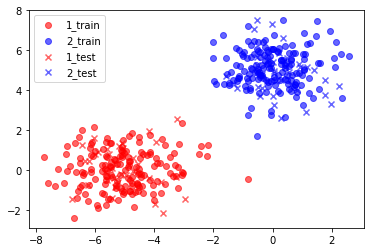

In [48]:
data1 = Dataset(mode='random')
x_train, x_test = data1.x_train, data1.x_test
y_train, y_test = data1.y_train, data1.y_test
print('Size of Dataset: ')
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test: {}".format(y_test.shape))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='x', c='blue')
plt.legend(handles=[c1, c2, c3, c4],labels=['1_train','2_train', '1_test', '2_test'],loc='best')
plt.show()

训练两个模型，统计准确率、运行时间和数据可视化。 **<font color="Red">（问题2）</font>**

训练PLA模型

In [49]:
classifier = PLA(dim=2)
start_time = time()
classifier.train(x_train, y_train)
end_time = time()
print('运行时间: %.3f' %(end_time - start_time))

W: [[-4.8639238   0.26291934]]
b: [1.]
W: [[-4.62532254 -3.64273207]]
b: [0.]
Finish training!
运行时间: 0.014


测试模型并可视化

accuracy: 1.00


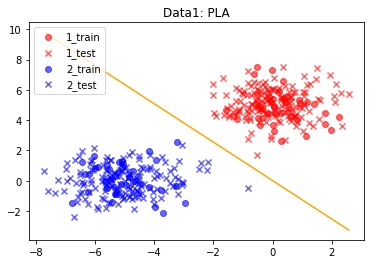

In [50]:
yh = classifier.inference(x_test,y_test)
w, b = classifier.W.squeeze(), classifier.b

plt.title('PLA classifier')
plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='x', c='blue')
plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='x', c='red')
plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='o', c='blue')
plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='o', c='red')

xmax, xmin = np.max(x_train[:, 0]), np.min(x_train[:, 0])
point1, point2 = [xmin, xmax], [- ( w[0] * xmin + b) / w[1],-(w[0] * xmax + b) / w[1]]
plt.plot(point1, point2, c='orange')
plt.legend(handles=[c1, c3, c2, c4],labels=['1_train','1_test','2_train','2_test'], loc='best')
plt.title('Data1: PLA')
plt.show()

采用Pocket算法

In [51]:
classifier = Pocket(dim=2)
start_time = time()
classifier.train(x_train,y_train)
end_time = time()
print('运行时间: %.3f'%(end_time - start_time))

运行时间: 0.001


测试模型并可视化

accuracy: 1.00


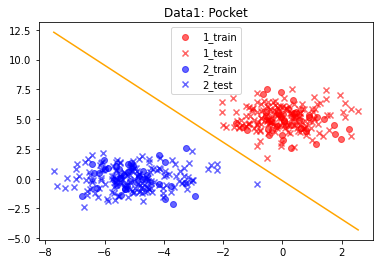

In [52]:
yh = classifier.inference(x_test,y_test)
w, b = classifier.W.squeeze(), classifier.b

plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='x', c='blue')
plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='x', c='red')
plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='o', c='blue')
plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='o', c='red')

xmax, xmin = np.max(x_train[:,0]), np.min(x_train[:,0])
point1, point2 = [xmin, xmax], [- (w[0] * xmin + b) / w[1],-(w[0] * xmax + b) / w[1]]
plt.plot(point1, point2, c='orange')
plt.legend(handles=[c1, c3, c2, c4],labels=['1_train','1_test','2_train','2_test'],loc='best')
plt.title('Data1: Pocket')
plt.show()

改变数据集的均值向量 **<font color="Red">（问题3）</font>**

Size of Dataset: 
x_train: (320, 2)
y_train: (320, 1)
x_test: (80, 2)
y_test: (80, 1)


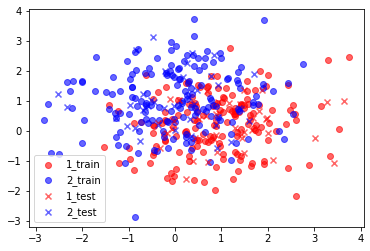

In [53]:
data2 = Dataset(mode='random', means1=[1,0], means2=[0,1])
x_train, x_test = data2.x_train, data2.x_test
y_train, y_test = data2.y_train, data2.y_test
print('Size of Dataset: ')
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test: {}".format(y_test.shape))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='x', c='blue')
plt.legend(handles=[c1, c2, c3, c4],labels=['1_train','2_train', '1_test', '2_test'],loc='best')
plt.show()

PLA算法无法收敛，故使用Pocket算法

In [54]:
classifier = Pocket(dim=2)
start_time = time()
classifier.train(x_train,y_train)
end_time = time()
print('运行时间: %.3f'%(end_time - start_time))

运行时间: 0.104


accuracy: 0.79


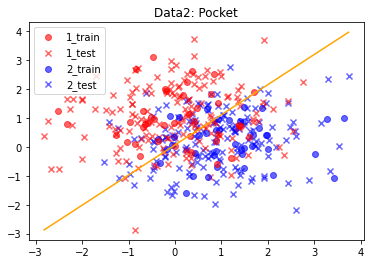

In [55]:
yh = classifier.inference(x_test,y_test)
w, b = classifier.W.squeeze(), classifier.b

plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='x', c='blue')
plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='x', c='red')
plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='o', c='blue')
plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='o', c='red')

xmax, xmin = np.max(x_train[:,0]), np.min(x_train[:,0])
point1, point2 = [xmin, xmax], [- (w[0] * xmin + b) / w[1], - (w[0] * xmax + b) / w[1]]
plt.plot(point1, point2, c='orange')
plt.legend(handles=[c1, c3, c2, c4],labels=['1_train','1_test','2_train','2_test'], loc='best')
plt.title('Data2: Pocket')
plt.show()

**结论** **<font color="Red">（问题4）</font>**

PLA算法的局限性在于对于线性不可分的数据无法收敛；

Pocket算法可以在线性不可分时，仍尽可能的进行分类。